<img src=https://raw.githubusercontent.com/ARCLeeds/arcleeds.github.io/master/assets/img/lighterblueText_wLogo_m2.1.png alt="Research Computing logo" style="width:900px;">

# IT TechTalk - Session 2: Text analysis approaches

## Agenda

- [Introduction](#Introduction)
- [Preprocessing](#Preprocessing)
- [Build a Bag of words corpus](#Building-a-bag-of-words-corpus-and-dictionary)
- [Building a topic model](#Building-the-topic-model)

## Introduction

Text analysis is a classic computational and data science problem.

![NLP](https://deeplearninganalytics.org/wp-content/uploads/2019/04/nlp.png)

Compared with regression and classification approaches on continuous and categorical dataset taking text data and deriving distinct insights is a far more complicated task. Text data and especially free text (text fields in sentence form) is typically classed as a form of unstructured data because of the various nuances introduced by languages.

With the ever increasing computational power has come a side-by-side improvements in approaches to text analysis. 

There are a number of different approaches to text analysis such as sentiment analysis, machine translation, information retrieval and much more. In this talk we'll focus specifically on **topic modelling**. An unsupervised statistical approach for identifying abstract 'topics' from within a collection of documents (corpus).

We'll look specifically at latent Dirichlet allocation (LDA), a topic modelling approach developed in [2002](http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA has become one of the most commonly used topic modelling approaches and many extensions of LDA have since been proposed.

We'll use financial complaints data from the [US Consumer Financial Protection Bureau](https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data) for this example.

In [1]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

We add some shell scripting here to create a data directory and download and unzip our data file.

In [2]:
%%bash 

if [ -d data/ ]; then
    echo "Data directory exists"
else
    mkdir data
fi

if test -f data/complaints.csv; then
    echo "Data file exists"
else 
    curl -LO http://files.consumerfinance.gov/ccdb/complaints.csv.zip; mv complaints.csv.zip data/ ;unzip data/complaints.csv.zip -d data/
fi

Data directory exists
Data file exists


Next we load this dataset into a pandas DataFrame python object. This is alot like a spreadsheet and allows for easy manipulation of columns and rows.

In [3]:
# import the dataset
# for demo purposes we'll use a subset of the data 5% of total
ticket_data = pd.read_csv('data/complaints.csv').sample(frac=0.05, random_state=42)

ticket_data.dropna(subset=["Consumer complaint narrative"], inplace=True)

print(ticket_data.shape)

ticket_data.head()

(28922, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
37261,2019-03-29,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,This debt does not belong to me. Please remove...,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",SC,NaN,NaN,Consent provided,Web,2019-03-29,Closed with explanation,Yes,NaN,3195825
1562446,2018-06-01,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was paid,Medial treatment done XX/XX/XXXX and Hospital ...,NaN,"AR Resources, Inc.",VA,22193,NaN,Consent provided,Web,2018-06-01,Closed with explanation,Yes,NaN,2924042
368313,2020-02-05,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,contacted credit bureau and let them know that...,NaN,"EQUIFAX, INC.",TN,NaN,NaN,Consent provided,Web,2020-02-05,Closed with explanation,Yes,NaN,3521708
514232,2017-09-15,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,This company is refusing to update my account ...,Company disputes the facts presented in the co...,"CREDIT BUREAU OF NAPA COUNTY, INC.",TX,NaN,NaN,Consent provided,Web,2017-09-15,Closed with explanation,Yes,NaN,2674967
299893,2019-12-17,Mortgage,VA mortgage,Trouble during payment process,NaN,Complaint and Qualified Written Request re pro...,NaN,"PENNYMAC LOAN SERVICES, LLC.",MI,NaN,Servicemember,Consent provided,Web,2019-12-17,Closed with explanation,Yes,NaN,3470877


In [49]:
ticket_data.Product.unique()

array(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit card or prepaid card', 'Student loan',
       'Credit reporting',
       'Money transfer, virtual currency, or money service',
       'Bank account or service', 'Credit card', 'Vehicle loan or lease',
       'Consumer Loan', 'Checking or savings account',
       'Payday loan, title loan, or personal loan', 'Prepaid card',
       'Other financial service', 'Money transfers', 'Payday loan'],
      dtype=object)

In [4]:
# lets peak and look what this looks like

ticket_data['Consumer complaint narrative'][:5].tolist()

['This debt does not belong to me. Please remove this immediately!',
 "Medial treatment done XX/XX/XXXX and Hospital claims I had no medical insurance. Went to Urgent care earlier that same day and that claim was processed XX/XX/XXXX per Urgent care office. I received a letter from AR Resources showing debt went to collection. Did not received letter from Original creditor, who was XXXX XXXX XXXX XXXX, XXXX. AR Resources placed collection on credit XX/XX/XXXX for {$710.00} and {$51.00} separately. the {$51.00} debt was paid through Insurance claim XX/XX/XXXX. The {$710.00} was paid per Healthare provider. The original creditor never processed claim, stating I had no Insurance and per new rules on Medical debt, must be 6 month prior to sending to collections. Collections placed XX/XX/XXXX. I've disputed this in XX/XX/XXXX. XXXX has also stated per phone call that it was procedded through claims.",
 'contacted credit bureau and let them know that I had got an email stating my information

## Preprocessing

Pre processing is a crucial step in any text analytics project. Text data on its own is very difficult for machines to understand and therefore it requires cleaning and preparing before building models. This often involves a number of steps such as:
- Tokenisation, converting a long string of words into a list of individual words i.e. "the cat sat on the mat" -> ["the", "cat", "sat", "on", "the", "mat"]
- Noise removal, most commonly removing punctuation or things like hyperlinks or emojis
- Stopword removal, removing common words that don't contain information such as the, and, or, a 
- Stemming or lemming, this is the process of reverting words to their root either by chopping off suffixes (stemming) or reverting to word lemma (lemming)
- Normalisation, commonly this means converting all words to lower or uppercase


In [5]:
# lets slice out the text data from our dataframe
subsample_text = ticket_data['Consumer complaint narrative'].tolist()

In [6]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short, stem_text

def basic_preprocess(list_of_strings):
    """
    A basic function that takes a list of strings and runs some basic
    gensim preprocessing to tokenise each string.
    
    Operations:
        - convert to lowercase
        - remove html tags
        - remove punctuation
        - remove numbers
        - remove short tokens (less than 3)
    
    Outputs a list of lists
    """
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short, stem_text]

    preproc_text = [preprocess_string(doc, CUSTOM_FILTERS) for doc in list_of_strings]
    
    return preproc_text

In [7]:
# what are stop words?

from gensim.parsing.preprocessing import STOPWORDS

print(STOPWORDS)

frozenset({'between', 'any', 'yet', 'thru', 'an', 'everything', 'full', 'did', 'yourself', 'sincere', 'them', 'was', 'move', 'somehow', 'give', 'during', 'nobody', 'who', 'would', 'has', 'otherwise', 'being', 'yours', 'himself', 'or', 'though', 'along', 'un', 'enough', 'thick', 'then', 'down', 'to', 'get', 'bottom', 'whereby', 'km', 'hereupon', 'have', 'for', 'empty', 'mine', 'what', 'there', 'hereafter', 'formerly', 'sixty', 'whatever', 'everywhere', 'etc', 'done', 'front', 'onto', 'ours', 'per', 'beside', 'cannot', 'almost', 'never', 'why', 'forty', 'couldnt', 'before', 'make', 'anything', 'using', 'when', 'it', 'something', 'most', 'side', 'else', 'since', 'below', 'six', 'this', 'will', 'used', 'without', 'through', 'just', 'next', 'had', 'too', 'unless', 'due', 'fill', 'well', 'can', 'is', 'herself', 'other', 'only', 'often', 'because', 'whenever', 'bill', 'once', 'twelve', 'throughout', 'latter', 'after', 're', 'cant', 'few', 'among', 'also', 'even', 'doing', 'system', 'fifteen',

In [8]:
import re

def remove_twitterisms(list_of_strings):
    """
    Some regular expression statements to remove twitter-isms
    
    Operations:
        - remove links
        - remove @tag
        - remove #tag
        
    Returns list of strings with the above removed
    """
    
    # removing some standard twitter-isms

    list_of_strings = [re.sub(r"http\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"@\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"#\S+", "", doc) for doc in list_of_strings]
    
    return list_of_strings

In [9]:
# removing emojis
# taken from https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b#gistcomment-3315605

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
def remove_redacted(string):
    
    string = [re.sub(r"(x|X){2,}", "", doc) for doc in string]
    
    return string

In [11]:
remove_redacted(['xx','x','test','XXX'])

['', 'x', 'test', '']

In [12]:
from gensim.models.phrases import Phrases

def n_gram(tokens):
    """Identifies common two/three word phrases using gensim module."""
    # Add bigrams and trigrams to docs (only ones that appear 10 times or more).
    # includes threshold kwarg (threshold score required by bigram)
    bigram = Phrases(tokens, min_count=10, threshold=100)
    trigram = Phrases(bigram[tokens], threshold = 100)

    for idx, val in enumerate(tokens):
        for token in bigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a bigram, add to document.bigram
                    tokens[idx].append(token)
        for token in trigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a trigram, add to document.
                    tokens[idx].append(token)
    return tokens

In [13]:
from nltk.stem import WordNetLemmatizer

def lemmatise(words):
    """
    Convert words to their lemma or root using WordNet lemmatizer
    """
    lemma = WordNetLemmatizer()
    # this function takes a list of lists of tokens
    return [[lemma.lemmatize(token,'v') for token in tokens] for tokens in words]

In [14]:
# next we implement the preprocessing steps

preprocessed_corpus = remove_twitterisms(subsample_text)

preprocessed_corpus = remove_redacted(preprocessed_corpus)

preprocessed_corpus = [remove_emoji(doc) for doc in preprocessed_corpus]

preprocessed_corpus = basic_preprocess(preprocessed_corpus)

# added stemming
#preprocessed_corpus = lemmatise(preprocessed_corpus)

In [15]:
# lets compare the original strings to the preprocessed strings
for orig, proc in zip(subsample_text[:5], preprocessed_corpus[:5]):
    
    print(orig)
    print(proc)
    print('\n')

This debt does not belong to me. Please remove this immediately!
['debt', 'belong', 'remov', 'immedi']


Medial treatment done XX/XX/XXXX and Hospital claims I had no medical insurance. Went to Urgent care earlier that same day and that claim was processed XX/XX/XXXX per Urgent care office. I received a letter from AR Resources showing debt went to collection. Did not received letter from Original creditor, who was XXXX XXXX XXXX XXXX, XXXX. AR Resources placed collection on credit XX/XX/XXXX for {$710.00} and {$51.00} separately. the {$51.00} debt was paid through Insurance claim XX/XX/XXXX. The {$710.00} was paid per Healthare provider. The original creditor never processed claim, stating I had no Insurance and per new rules on Medical debt, must be 6 month prior to sending to collections. Collections placed XX/XX/XXXX. I've disputed this in XX/XX/XXXX. XXXX has also stated per phone call that it was procedded through claims.
['medial', 'treatment', 'hospit', 'claim', 'medic', 'insur

## Building a bag of words corpus and dictionary

In [16]:
import numpy as np
from gensim.corpora import Dictionary

def bag_of_word_processing(corpus_of_tokens, lower_extreme, upper_extreme):
    """
    Take the list of tokens and convert them into a bag-of-words (BoW) format.

    Extended description of function.

    :param list of lists corpus_of_tokens: a list of strings produced during preprocessing representing all documents in corpus
    :param int lower_extreme: Description of arg2.
    :param float upper_extreme: the upper extreme filter limit, words are excluded if they occur in more documents than the proportion specified here
    :return: gensim.corpora.dictionary.Dictionary object 
    :return: list representing BoW corpus
    
    """

    # Create a dictionary representation of the documents.
    # gensim Dictionary function creates tokens -> tokenID dict
    dictionary = Dictionary(corpus_of_tokens)
    print('Number of unique words in initital documents:', len(dictionary))

    org_dict = len(dictionary)

    # Filter out words that occur less than 10 documents, or more than 70% of the documents.
    dictionary.filter_extremes(no_below=lower_extreme, no_above=upper_extreme)
    print('Number of unique words after removing rare and common words:', len(dictionary))

    filt_dict = len(dictionary)

    print('Token reduction of: ' + str((1-filt_dict/org_dict)*100)+'%')

    # transform to bag of words
    corpus = [dictionary.doc2bow(doc) for doc in corpus_of_tokens]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # output on document length
    print('Average number of words per document before BoW transform: ', np.mean([len(item) for item in preprocessed_corpus]))
    print('Average number of words per BoW document: ',np.mean([len(corpus[i]) for i in range(len(corpus))]))

    return dictionary, corpus

In [17]:
working_dict, working_corpus = bag_of_word_processing(preprocessed_corpus, 10, 0.7)

Number of unique words in initital documents: 18361
Number of unique words after removing rare and common words: 4196
Token reduction of: 77.14721420401939%
Number of unique tokens: 4196
Number of documents: 28922
Average number of words per document before BoW transform:  73.25924901459096
Average number of words per BoW document:  44.38448240094046


## Building the topic model

We now have processed our initial texts into components that machines can interact with and we're ready to create a topic model!

In [18]:
from gensim.models import CoherenceModel, ldamulticore

def long_topic_scan(dictionary, corpus,  texts, limit, start=2, step=3):
    """
    Identify the topic number with the highest coherence score out of a broad range of numbers
    Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts (doc_clean)
    limit : Max num of topics
    start : int starting topic number
    step : int increment from one topic number to another until limit is reached
    Returns:
    coherence_df : pd.DataFrame containing topic number and its calculated coherence score
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    graphical outputs
    """
    coherence_dict = dict()

    for num_topics in range(start, limit, step):
        model = ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=2)
        coherencemodel1 = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_dict[num_topics] = coherencemodel1.get_coherence()

    coherence_df = pd.DataFrame(pd.Series(coherence_dict)).reset_index()

    coherence_df.columns = ['Num_topics','Coherence_score']

    # Show graph
    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot(coherence_df['Num_topics'], coherence_df['Coherence_score'])
    ax.set_xlabel("No. of topics", fontweight='bold')
    ax.set_ylabel("Cv Coherence score", fontweight='bold')
    ax.axvline(coherence_df[coherence_df['Coherence_score'] == coherence_df['Coherence_score'].max()]['Num_topics'].tolist(), color='red')

    return coherence_df

Wall time: 33min 14s


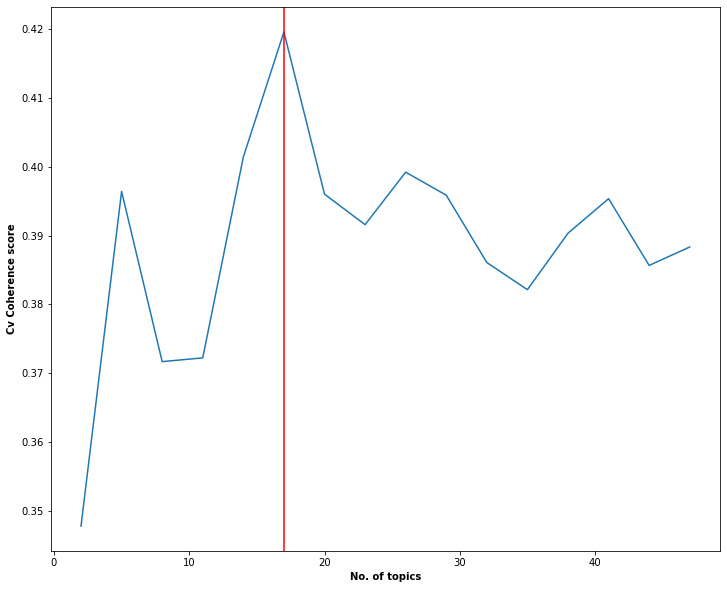

In [19]:
%%time

coh_model = long_topic_scan(working_dict, working_corpus, preprocessed_corpus, limit=50, step=3, start=2)

In [20]:
coh_model.sort_values(ascending = False, by='Coherence_score').head(1)

,Num_topics,Coherence_score
5,17,0.419565


In [59]:
# next we build our working model using the topic number we've determined

working_model = ldamulticore.LdaMulticore(corpus=working_corpus, num_topics=17, id2word=working_dict, workers=2)

coherencemodel1 = CoherenceModel(model=working_model, texts=preprocessed_corpus, dictionary=working_dict, coherence='c_v')

In [60]:
coherencemodel1.get_coherence()

0.40126157343550267

In [61]:
# ideas about inspecting the model
working_model.show_topics(-1)

[(0,
  '0.046*"credit" + 0.022*"debt" + 0.018*"call" + 0.018*"compani" + 0.015*"card" + 0.015*"time" + 0.014*"report" + 0.014*"paid" + 0.013*"collect" + 0.012*"account"'),
 (1,
  '0.053*"report" + 0.052*"credit" + 0.029*"debt" + 0.023*"inform" + 0.019*"account" + 0.015*"collect" + 0.014*"remov" + 0.013*"compani" + 0.012*"request" + 0.012*"letter"'),
 (2,
  '0.056*"account" + 0.051*"report" + 0.047*"credit" + 0.022*"payment" + 0.019*"disput" + 0.012*"date" + 0.012*"late" + 0.010*"inform" + 0.009*"time" + 0.009*"remov"'),
 (3,
  '0.055*"account" + 0.015*"number" + 0.015*"collect" + 0.014*"inform" + 0.013*"debt" + 0.012*"receiv" + 0.010*"report" + 0.009*"credit" + 0.009*"provid" + 0.008*"state"'),
 (4,
  '0.027*"loan" + 0.023*"well" + 0.021*"fargo" + 0.018*"account" + 0.011*"payment" + 0.011*"time" + 0.010*"check" + 0.010*"receiv" + 0.010*"said" + 0.009*"request"'),
 (5,
  '0.061*"loan" + 0.032*"payment" + 0.012*"time" + 0.012*"navient" + 0.011*"pai" + 0.011*"student" + 0.010*"year" + 0.0

In [62]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(working_model, working_corpus, dictionary=working_model.id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.049136  0.094897       1        1  12.400408
1     -0.136796 -0.022397       2        1  11.631107
7      0.064051  0.037222       3        1   9.628567
2     -0.072699  0.029029       4        1   8.640743
16    -0.150822 -0.031616       5        1   6.753943
0     -0.004660  0.033342       6        1   6.133196
12     0.077470 -0.086042       7        1   5.781773
5      0.065969 -0.060324       8        1   5.408792
8      0.091541 -0.038270       9        1   5.304756
10     0.076248  0.020617      10        1   5.213370
3     -0.049510 -0.013458      11        1   4.862650
14    -0.030779  0.087157      12        1   4.537846
13     0.009149  0.019872      13        1   3.610771
15    -0.022401  0.022980      14        1   3.443043
4      0.070899 -0.005037      15        1   2.921674
6     -0.063641 -0.055599      16        1   1.890292
9      0.026845 -0.032372      17        1   1.837063, topic_info=        Term          Freq         Total Category  logprob  loglift
53    report  38737.000000  38737.000000  Default  30.0000  30.0000
7     credit  46794.000000  46794.000000  Default  29.0000  29.0000
132     loan  21296.000000  21296.000000  Default  28.0000  28.0000
322  payment  29263.000000  29263.000000  Default  27.0000  27.0000
60   account  45224.000000  45224.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
170  request    214.759781  12248.446289  Topic17  -5.1823  -0.0466
218      ask    191.866516  10998.240234  Topic17  -5.2950  -0.0517
38      call    202.993820  17861.833984  Topic17  -5.2386  -0.4802
62   compani    197.385925  15309.840820  Topic17  -5.2666  -0.3541
32     state    181.797943  12761.454102  Topic17  -5.3489  -0.2543

[1276 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3639      1  0.079690     abet
3639      2  0.079690     abet
3639      7  0.637519     abet
3639      8  0.079690     abet
60        1  0.151688  account
...     ...       ...      ...
1271     12  0.023282       yr
1271     13  0.004656       yr
1271     15  0.013969       yr
1271     16  0.013969       yr
1271     17  0.018626       yr

[8795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 8, 3, 17, 1, 13, 6, 9, 11, 4, 15, 14, 16, 5, 7, 10])

In [63]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    # enumerate each topic and return number of topic, row of topic numbers and probabilities
    for row in ldamodel[corpus]:
        # sort row data into descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        # split row value into j (numerated), topic number, topic probability
        # select top numerated (top ranked topic), retrieve topic text and join it altogether
        # combine into pandas dataframe with topic text and probability of topic
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wordprob = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wordprob])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1,
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # add column names
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original text']

    return sent_topics_df

In [64]:
topic_df = format_topics_sentences(working_model, working_corpus, ticket_data["Consumer complaint narrative"].tolist())

In [65]:
topic_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original text
0,2.0,0.8118,"report, credit, debt, inform, account, collect...",This debt does not belong to me. Please remove...
1,7.0,0.7074,"insur, report, claim, credit, account, collect...",Medial treatment done XX/XX/XXXX and Hospital ...
2,15.0,0.3263,"account, credit, charg, report, bank, card, re...",contacted credit bureau and let them know that...
3,3.0,0.9144,"account, report, credit, payment, disput, date...",This company is refusing to update my account ...
4,13.0,0.7827,"loan, home, mortgag, modif, document, bank, st...",Complaint and Qualified Written Request re pro...
...,...,...,...,...
28917,3.0,0.6905,"account, report, credit, payment, disput, date...",FEDERAL LOAN SERVICING ( Account # XXXX ) This...
28918,2.0,0.3548,"report, credit, debt, inform, account, collect...",I paid to have my credit repaired from Expert ...
28919,12.0,0.4384,"card, account, bank, call, monei, receiv, chec...","Capital One marketed to me, presumably based o..."
28920,3.0,0.9144,"account, report, credit, payment, disput, date...",Account show in credit report as open even its...


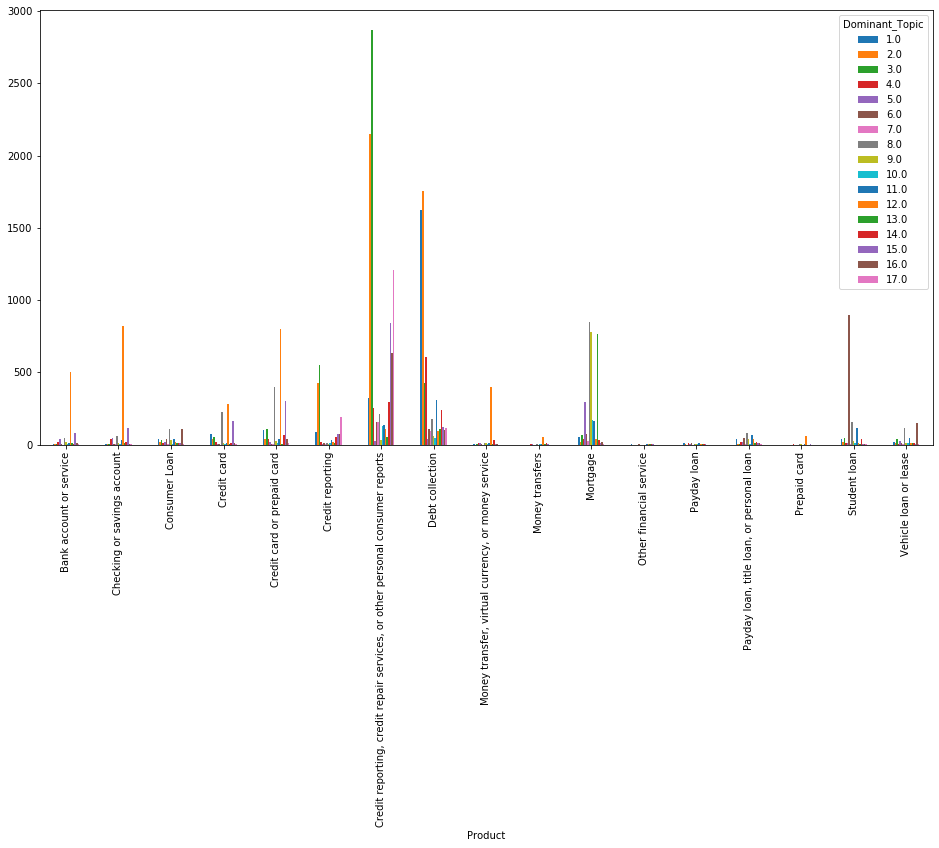

In [66]:
ticket_data.reset_index().join(topic_df).groupby('Product')['Dominant_Topic'].value_counts().unstack().plot.bar(figsize=(16,8))

In [67]:
def get_top3_docs(dominant_topic_frame):

    table_lst = []

    # create dataframe of top 3 most representative docs for each topic
    for i in range(1, int(dominant_topic_frame['Dominant_Topic'].max())):
        # get indexes
        indy = dominant_topic_frame[dominant_topic_frame['Dominant_Topic'] == i].sort_values(by='Perc_Contribution', ascending=False).index.tolist()
        # test how many documents passed
        if len(indy) <= 3:
            for idx in indy:
                table_lst.append(dominant_topic_frame.iloc[idx, :])
        else:
            table_lst.append(dominant_topic_frame.iloc[indy[0], :])
            table_lst.append(dominant_topic_frame.iloc[indy[1], :])
            table_lst.append(dominant_topic_frame.iloc[indy[2], :])

    new_eg_df = pd.DataFrame(table_lst)

    return new_eg_df

In [68]:
top3_df = get_top3_docs(topic_df)

In [69]:
top3_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original text
6828,1.0,0.9909,"credit, debt, call, compani, card, time, repor...",I have been getting numerous calls from XXXX o...
15026,1.0,0.9907,"credit, debt, call, compani, card, time, repor...",At approximately XXXX I received a phone call ...
7724,1.0,0.9902,"credit, debt, call, compani, card, time, repor...",I received a phone call from XXXX at XXXX at m...
13164,2.0,0.9973,"report, credit, debt, inform, account, collect...",Recently I sent a complaint to CFPB with the a...
12125,2.0,0.9971,"report, credit, debt, inform, account, collect...",On XX/XX/2018 a certified letter was sent to X...


In [70]:
for topic in top3_df.Dominant_Topic.unique():
    
    print(f"Topic number {topic}")
    print(top3_df[top3_df.Dominant_Topic == topic].Topic_Keywords.tolist()[0], '\n')
    
    subset_df = top3_df[top3_df.Dominant_Topic == topic]['Original text'].tolist()
    
    for idx, item in enumerate(subset_df):
        print("text ", str(idx))
        print(item, '\n')
    
    print("----------")

Topic number 1.0
credit, debt, call, compani, card, time, report, paid, collect, account 

text  0
I have been getting numerous calls from XXXX over the past month 4-5 times daily. I would normally ignore the call because i am unfamiliar with the phone number. The times i would answer the call no one would respond, what would happen is that the line becomes silent and then the phone would hang up. I was a bit curious of the person that could be calling and wondered if it was someone who probably changed their number or probably just an important call and so i decided to dial the number on XXXX/XXXX/XXXX after which a female voice answered and said " Is this XXXX XXXX '' so i responded and asked " Who do i have the pleasure of speaking to '' the female voice kept asking if my name is ... ... ... .., to which i responded that it is only mannerly to introduce yourself and say what you are calling about, the person still decided to kept asking me to verify my name, address, and last XXXX d